### Dataset loading

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, models, transforms

import numpy as np

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

### Model loading

In [2]:
def get_vgg_model(n_classes=3, hidden_layer_width=4096, fine_tune=False):
    vgg16 = models.vgg16_bn(pretrained=True)
    
    for param in vgg16.parameters():
        param.requires_grad = False
    
    classifier = list(vgg16.classifier.children())[:-1]
    classifier += [
        nn.Linear(4096, hidden_layer_width),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_layer_width, n_classes)
    ]
    
    vgg16.classifier = nn.Sequential(*classifier)
    
    if fine_tune:
        for param in vgg16.classifier.parameters():
            param.requires_grad = True
    
    return vgg16

In [3]:
model_tl = get_vgg_model()
model_ft = get_vgg_model(fine_tune=True)

In [4]:
model_tl

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

### Loading data

In [5]:
folder_train = datasets.ImageFolder('clean-dataset/train', transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
]), )
folder_val = datasets.ImageFolder('clean-dataset/validation', transform=transforms.ToTensor())

In [6]:
batch_size = 32

loader_train = torch.utils.data.DataLoader(folder_train, batch_size, num_workers=4, shuffle=True)
loader_val = torch.utils.data.DataLoader(folder_val, batch_size, num_workers=4, shuffle=True)

In [7]:
folder_train.classes

['pumpkin', 'tomato', 'watermelon']

### Train model

In [8]:
def fit_model(model, criterion, optimizer, loader, val_loader=None, epochs=1, log_interval=100, use_cuda=False):
    if use_cuda:
        model = model.cuda()
    
    for epoch in range(1, epochs + 1):
        model.train()
        
        print('Epoch {}/{}'.format(epoch, epochs))
        for batch, (data, target) in enumerate(loader):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            if use_cuda:
                del data, target
            
            if batch % log_interval == 0:
                print('Batch [{}/{} ({:.0f}%)] Loss: {:.3f}'.format(batch, len(loader), 100.0 * batch / len(loader), loss.item()))
        
        model.eval()
        if val_loader:
            eval_model(model, criterion, val_loader)

In [9]:
def eval_model(model, criterion, loader):
    losses = []
    good_answers = 0
    
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            loss = criterion(output, target)
            losses.append(loss.item())
            good_answers += (output.argmax(dim=1) == target).sum().item()
            
    avg_loss = np.mean(losses)
    accuracy = good_answers / len(loader.dataset)
    print('Eval loss = {:.3f}, eval accuracy = {:.3f}'.format(avg_loss, accuracy))
    
    return avg_loss, accuracy

In [10]:
fit_model(model_tl, nn.CrossEntropyLoss(),
          torch.optim.SGD(model_tl.parameters(), lr=0.001, momentum=0.9), 
          loader_train, loader_val, epochs=5, log_interval=4)

Epoch 1/5
Batch [0/19 (0%)] Loss: 1.098
Batch [4/19 (21%)] Loss: 1.075
Batch [8/19 (42%)] Loss: 1.013
Batch [12/19 (63%)] Loss: 0.917
Batch [16/19 (84%)] Loss: 0.800
Eval loss = 0.764, eval accuracy = 0.913
Epoch 2/5
Batch [0/19 (0%)] Loss: 0.756
Batch [4/19 (21%)] Loss: 0.671
Batch [8/19 (42%)] Loss: 0.622
Batch [12/19 (63%)] Loss: 0.492
Batch [16/19 (84%)] Loss: 0.508
Eval loss = 0.422, eval accuracy = 0.987
Epoch 3/5
Batch [0/19 (0%)] Loss: 0.492
Batch [4/19 (21%)] Loss: 0.417
Batch [8/19 (42%)] Loss: 0.400
Batch [12/19 (63%)] Loss: 0.481
Batch [16/19 (84%)] Loss: 0.302
Eval loss = 0.276, eval accuracy = 0.967
Epoch 4/5
Batch [0/19 (0%)] Loss: 0.323
Batch [4/19 (21%)] Loss: 0.249
Batch [8/19 (42%)] Loss: 0.306
Batch [12/19 (63%)] Loss: 0.212
Batch [16/19 (84%)] Loss: 0.210
Eval loss = 0.192, eval accuracy = 0.987
Epoch 5/5
Batch [0/19 (0%)] Loss: 0.244
Batch [4/19 (21%)] Loss: 0.180
Batch [8/19 (42%)] Loss: 0.172
Batch [12/19 (63%)] Loss: 0.281
Batch [16/19 (84%)] Loss: 0.167
Eval l

In [33]:
def visualize(model, loader, max_images = 6):
    data, targets = next(iter(loader))

    data = data[:max_images]
    targets = targets[:max_images]
    
    with torch.no_grad():
        output = model(data)
    probas = torch.softmax(output, 1)
    
    data, probas, targets = data.numpy(), probas.numpy(), targets.numpy()
    data = np.transpose(data, (0, 2, 3, 1))
    
    classes = loader.dataset.classes
    
    for i in range(len(data)):
        real_class, pred_class, proba = targets[i], probas[i].argmax(), probas[i].max()
        
        plt.title('Class "{}" predicted "{}" probability {:.3f}'.format(
            classes[real_class], classes[pred_class], proba
        ))
        plt.imshow(data[i])
        plt.show()

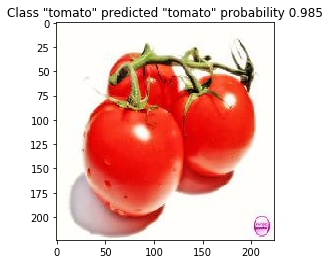

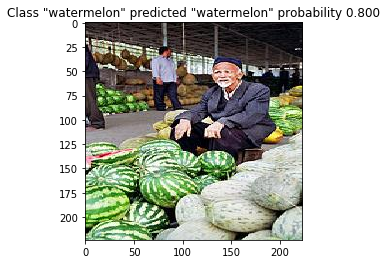

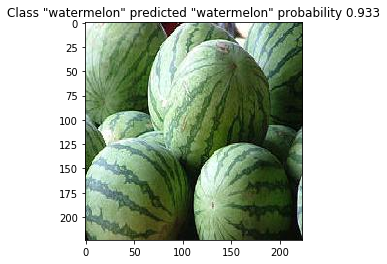

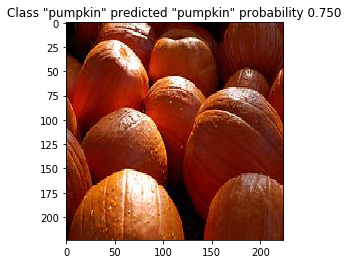

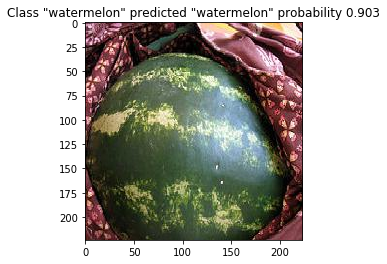

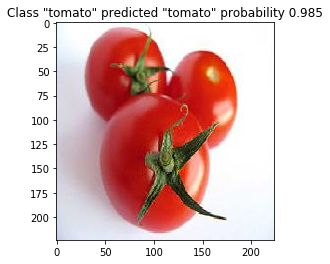

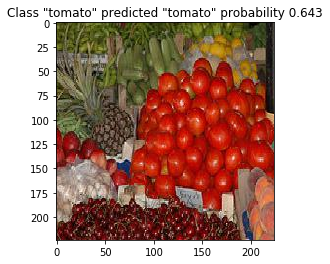

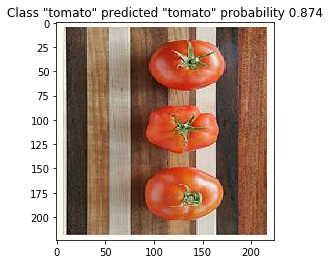

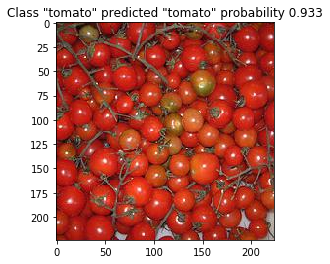

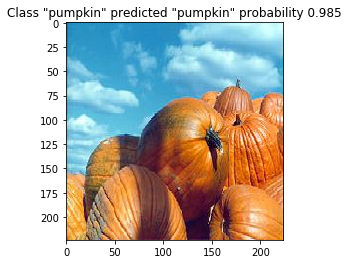

In [35]:
visualize(model_tl, loader_val, 10)

In [39]:
fit_model(model_ft, nn.CrossEntropyLoss(), 
          torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9), 
          loader_train, loader_val, epochs=5, log_interval=4)

Epoch 1/5
Batch [0/19 (0%)] Loss: 1.099
Batch [4/19 (21%)] Loss: 1.070
Batch [8/19 (42%)] Loss: 1.044
Batch [12/19 (63%)] Loss: 0.897
Batch [16/19 (84%)] Loss: 0.791
Eval loss = 0.745, eval accuracy = 0.953
Epoch 2/5
Batch [0/19 (0%)] Loss: 0.719
Batch [4/19 (21%)] Loss: 0.678
Batch [8/19 (42%)] Loss: 0.558
Batch [12/19 (63%)] Loss: 0.459
Batch [16/19 (84%)] Loss: 0.482
Eval loss = 0.368, eval accuracy = 0.980
Epoch 3/5
Batch [0/19 (0%)] Loss: 0.382
Batch [4/19 (21%)] Loss: 0.372
Batch [8/19 (42%)] Loss: 0.396
Batch [12/19 (63%)] Loss: 0.348
Batch [16/19 (84%)] Loss: 0.217
Eval loss = 0.202, eval accuracy = 0.987
Epoch 4/5
Batch [0/19 (0%)] Loss: 0.223
Batch [4/19 (21%)] Loss: 0.215
Batch [8/19 (42%)] Loss: 0.179
Batch [12/19 (63%)] Loss: 0.148
Batch [16/19 (84%)] Loss: 0.180
Eval loss = 0.122, eval accuracy = 0.980
Epoch 5/5
Batch [0/19 (0%)] Loss: 0.141
Batch [4/19 (21%)] Loss: 0.075
Batch [8/19 (42%)] Loss: 0.144
Batch [12/19 (63%)] Loss: 0.196
Batch [16/19 (84%)] Loss: 0.143
Eval l

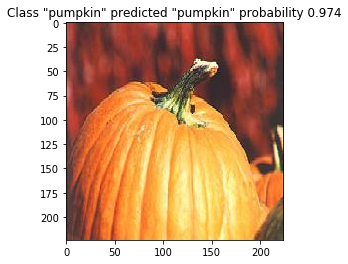

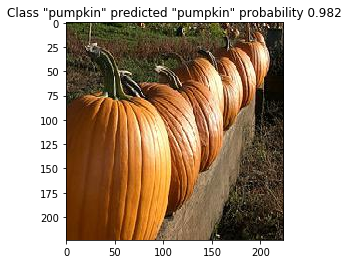

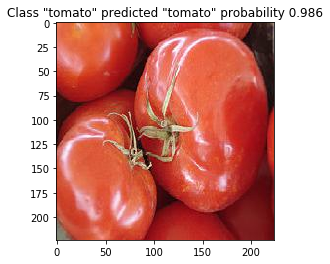

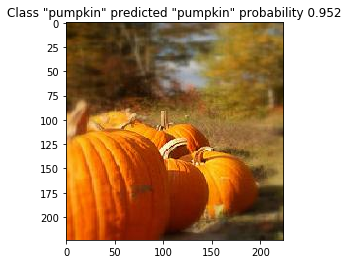

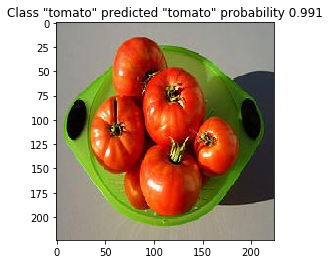

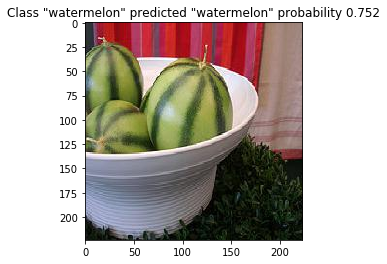

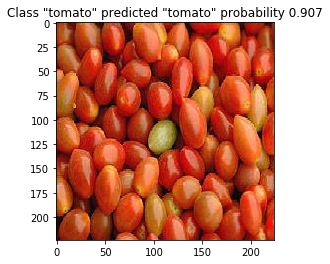

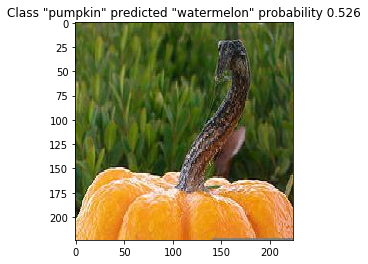

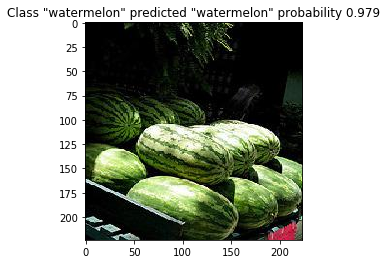

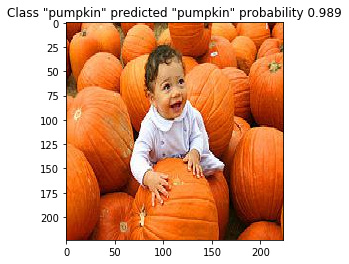

In [40]:
visualize(model_ft, loader_val, 10)

### Show errors 

In [48]:
def show_model_errors(model, loader):

    errors = []

    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            preds = output.argmax(dim=1)
            not_equals = (preds != target).numpy()

            error_indexes = np.where(not_equals)[0]

            for index in error_indexes:
                errors.append({
                    'image' : data[index],
                    'probas' : torch.softmax(output[index], 0),
                    'real' : target[index].item(),
                })
    
    classes = loader.dataset.classes
    for err in errors:
        pred_class = err['probas'].argmax().item()

        plt.title('Real class "{}"({}) predicted "{}"({}) probas {}'.format(
            classes[err['real']], err['real'],
            classes[pred_class], pred_class,
            err['probas'].numpy()
        ))
        plt.imshow(np.transpose(err['image'].numpy(), (1, 2, 0)))
        plt.show()

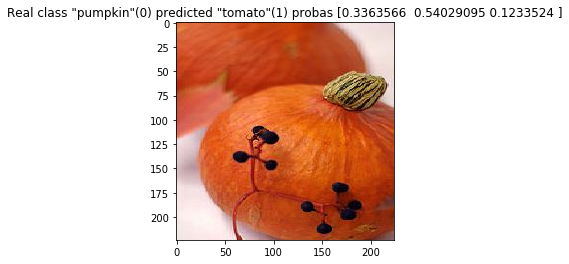

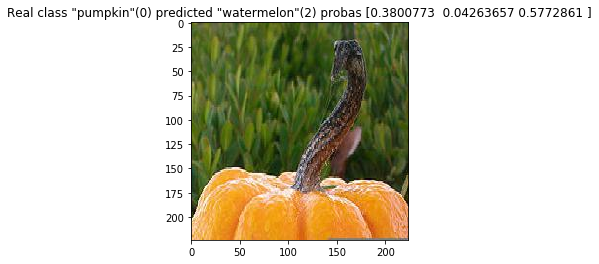

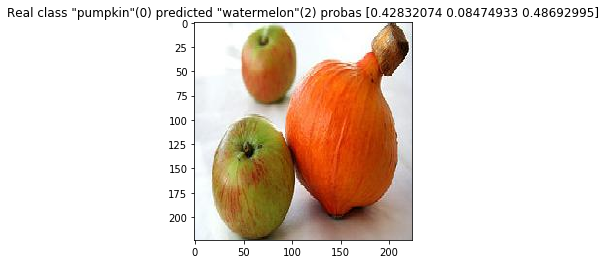

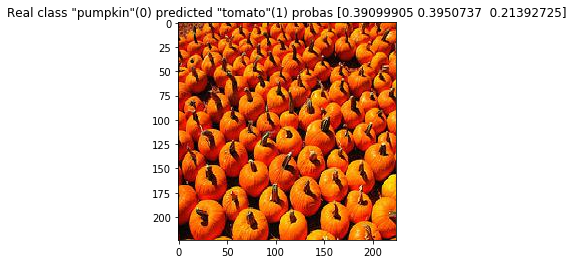

In [49]:
show_model_errors(model_tl, loader_val)

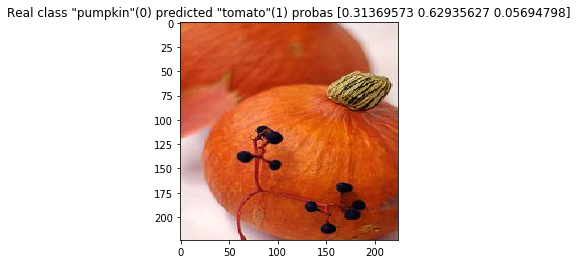

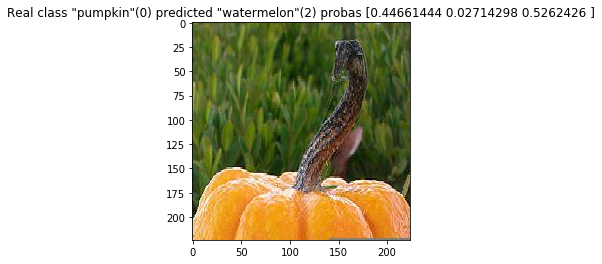

In [50]:
show_model_errors(model_ft, loader_val)